In [6]:
#A script comparing whether the PACKER and NPacker models are identical.


#First, generate predictions using some parm values

#A replacement for execfile if using python 3?
exec(open("Imports.py").read())
exec(open("ImportModels.py").read())

import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import Modules.Funcs as funcs

dbname = 'experiments-5con.db'#raw data
# dataname = 'xcrABC' #for parms
# exec(open('validate_data.py').read())

con = sqlite3.connect(dbname)
# participants = pd.read_sql_query("SELECT participant, condition from participants", con)
# generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()

# options for the optimization routine                                                                                                                         
options = dict(
    method = 'Nelder-Mead',
    options = dict(maxiter = 500, disp = False),
    tol = 0.01,
)


betas = [40,33,50]

crow = [[10, 12, 14, 16],betas] #similar to row with a couple of close betas
cxor = [[0, 10, 70, 80],betas] #similar to xor with a couple of close betas
cclu = [[14, 16, 32, 34],betas] #similar to cluster with a couple of close betas
ccor = [[0, 8, 72, 80],betas] #similar to corner with a couple of close betas

categorySets = [crow,cxor,cclu,ccor]


0
[3.350839285980715, 1.5260584367923429, 0.7295425948174776]
1
[1.1794567375947325, 0.17656341690107252, 0.823921184827976]
2
[4.3713656272166235, 2.9691597133242276, 0.9791407919146573]
3
[0.5609745558944824, 0.08052231629601506, 1.4707708190931428]


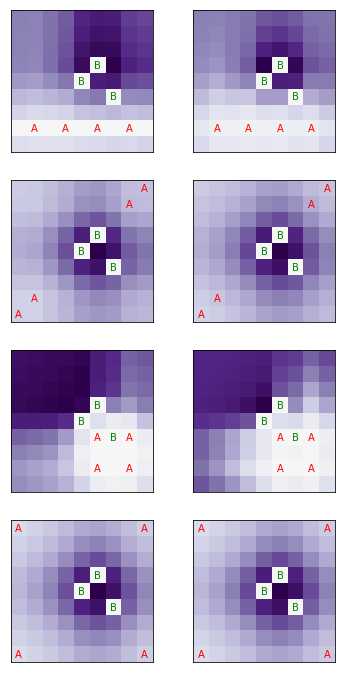

In [3]:
#Generate responses from NPacker
ntrials = 10000
setparms = {'negwt':5,'specificity':1,'theta_cntrst':1,'theta_target':1}

f,ax = plt.subplots(len(categorySets),2,figsize=(6,3*len(categorySets)))
for ci,categoriesi in enumerate(categorySets):
    print(ci)
    categories = [stimuli[np.array(i,dtype=int),:] for i in categoriesi if len(i)>0]
    nps = NPacker(categories,setparms,wrap_ax=None).get_generation_ps(stimuli,1,'generate')

    responsesCounts = np.random.multinomial(ntrials,nps)
    #Convert counts to array of responses
    responses = []
    for ri,r in enumerate(responsesCounts):
        responses += [ri for i in range(r)]

    #Create trial object -- simple one trial for each point across entire distribution
    # points = 9**2
    # responses = range(points) #See cell above
    participants = range(ntrials)
    trials = 0
    category = 'Beta'
    categoriespd = [categoriesi for i in range(ntrials)]

    generation = pd.DataFrame({'participant':participants,'stimulus':responses})
                              # 'trial':trials,'category':category,'categories':categories})
    generation['trial'] = trials
    generation['categories'] = categoriespd
    generation['category'] = category

    #Generate trial set
    trials = Simulation.Trialset(stimuli)
    trials = trials.add_frame(generation)
    trials.task = 'generate'


    inits = [1.5,1.5,1.5]#{'specificity':1.5,'theta_cntrst':1.5,'theta_target':1.5}
    #Run the fits
    res = Simulation.hillclimber(Packer, trials, options,
                                 inits=inits, results = False,
                                 callbackstyle=None) #can use 'iter','none','.'       
    fitparm = res.x
    print(fitparm)
    # ps = NPacker(categories,setparms,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    
    pps = Packer(categories,fitparm,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    ps = [nps,pps]

    STAT_LIMS = (-1.0, 1.0)
    betacol = ['green' for bi in range(len(categories[1]))]

    for i in range(2):
        gps = funcs.gradientroll(ps[i],'roll')[:,:,0]
        ps_ElRange = gps.max()-gps.min();
        plotVals = (gps-gps.min())/ps_ElRange
        gammas = []
        funcs.plotgradient(ax[ci,i], plotVals, categories[0], categories[1], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
#         ax[ci].set_title()
        # ax[ci].set_title(catstr[ci])

In [160]:
pps

array([0.01986031, 0.01756005, 0.01412272, 0.00960491, 0.00485517,
       0.001277  , 0.00209708, 0.00122578, 0.00441262, 0.01756005,
       0.01412272, 0.00960491, 0.00485517, 0.00145167, 0.00013659,
       0.0003286 , 0.00012705, 0.00122578, 0.01879607, 0.01592931,
       0.0118853 , 0.00707831, 0.00282885, 0.00037354, 0.00086704,
       0.0003286 , 0.00209708, 0.01872192, 0.01581827, 0.01173906,
       0.00692492, 0.00272127, 0.00025606, 0.        , 0.00020408,
       0.00160222, 0.02213967, 0.02128278, 0.01984683, 0.01753896,
       0.        , 0.00272127, 0.00422649, 0.00182138, 0.00551928,
       0.02263905, 0.02213967, 0.02128278, 0.01984683, 0.01753896,
       0.00692492, 0.008881  , 0.00551928, 0.01032656, 0.0229262 ,
       0.02263905, 0.02213967, 0.02128278, 0.01984683, 0.01173906,
       0.01351102, 0.01032656, 0.01471285, 0.02309006, 0.0229262 ,
       0.02263905, 0.02213967, 0.02128278, 0.01581827, 0.01712613,
       0.01471285, 0.01797099, 0.02318318, 0.02309006, 0.02292

0
[1.2744604943323095, 0.9484682525186289, 0.8768653539173968]
1
[0.7420023662576228, 1.4377780952266044, 1.2182473976166428]
2
[1.0045995519286075, 0.990157955874486, 0.9924546849153918]
3
[0.8747802094786248, 0.9894692559168304, 1.1098179371224837]


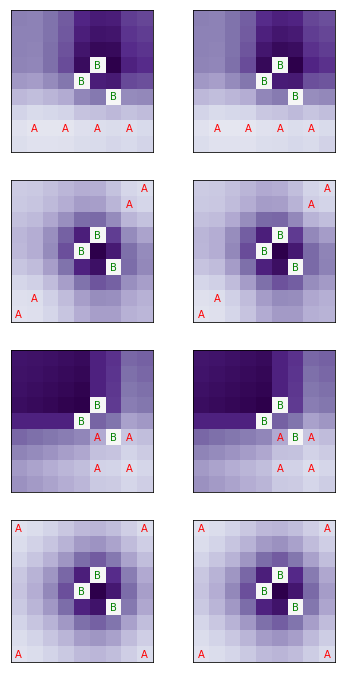

In [5]:
#Do the same but as model recovery
ntrials = 10000
f,ax = plt.subplots(len(categorySets),2,figsize=(6,3*len(categorySets)))
setparmsPacker = setparms
setparmsPacker.pop('negwt',None)
for ci,categoriesi in enumerate(categorySets):
    print(ci)
    categories = [stimuli[np.array(i,dtype=int),:] for i in categoriesi if len(i)>0]
    
    nps = Packer(categories,setparmsPacker,wrap_ax=None).get_generation_ps(stimuli,1,'generate')

    responsesCounts = np.random.multinomial(ntrials,nps)
    #Convert counts to array of responses
    responses = []
    for ri,r in enumerate(responsesCounts):
        responses += [ri for i in range(r)]

    #Create trial object -- simple one trial for each point across entire distribution
    # points = 9**2
    # responses = range(points) #See cell above
    participants = range(ntrials)
    trials = 0
    category = 'Beta'
    categoriespd = [categoriesi for i in range(ntrials)]

    generation = pd.DataFrame({'participant':participants,'stimulus':responses})
                              # 'trial':trials,'category':category,'categories':categories})
    generation['trial'] = trials
    generation['categories'] = categoriespd
    generation['category'] = category

    #Generate trial set
    trials = Simulation.Trialset(stimuli)
    trials = trials.add_frame(generation)
    trials.task = 'generate'


    inits = [1.5,1.5,1.5]#{'specificity':1.5,'theta_cntrst':1.5,'theta_target':1.5}
    #Run the fits
    res = Simulation.hillclimber(Packer, trials, options,
                                 inits=inits, results = False,
                                 callbackstyle=None) #can use 'iter','none','.'       
    fitparm = res.x
    print(fitparm)
    # ps = NPacker(categories,setparms,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    
    pps = Packer(categories,fitparm,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    ps = [nps,pps]

    STAT_LIMS = (-1.0, 1.0)
    betacol = ['green' for bi in range(len(categories[1]))]

    for i in range(2):
        gps = funcs.gradientroll(ps[i],'roll')[:,:,0]
        ps_ElRange = gps.max()-gps.min();
        plotVals = (gps-gps.min())/ps_ElRange
        gammas = []
        funcs.plotgradient(ax[ci,i], plotVals, categories[0], categories[1], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
#         ax[ci].set_title()
        # ax[ci].set_title(catstr[ci])

In [ ]:
#Generate responses from NPacker
ntrials = 10000
f,ax = plt.subplots(len(categorySets),2,figsize=(6,3*len(categorySets)))
for ci,categoriesi in enumerate(categorySets):
    print(ci)
    categories = [stimuli[np.array(i,dtype=int),:] for i in categoriesi if len(i)>0]
    nps = NPacker(categories,setparms,wrap_ax=None).get_generation_ps(stimuli,1,'generate')

    responsesCounts = np.random.multinomial(ntrials,nps)
    #Convert counts to array of responses
    responses = []
    for ri,r in enumerate(responsesCounts):
        responses += [ri for i in range(r)]

    #Create trial object -- simple one trial for each point across entire distribution
    # points = 9**2
    # responses = range(points) #See cell above
    participants = range(ntrials)
    trials = 0
    category = 'Beta'
    categoriespd = [categoriesi for i in range(ntrials)]

    generation = pd.DataFrame({'participant':participants,'stimulus':responses})
                              # 'trial':trials,'category':category,'categories':categories})
    generation['trial'] = trials
    generation['categories'] = categoriespd
    generation['category'] = category

    #Generate trial set
    trials = Simulation.Trialset(stimuli)
    trials = trials.add_frame(generation)
    trials.task = 'generate'


    inits = [1.5,1.5,1.5]#{'specificity':1.5,'theta_cntrst':1.5,'theta_target':1.5}
    #Run the fits
    res = Simulation.hillclimber(Packer, trials, options,
                                 inits=inits, results = False,
                                 callbackstyle=None) #can use 'iter','none','.'       
    fitparm = res.x
    print(fitparm)
    # ps = NPacker(categories,setparms,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    
    pps = Packer(categories,fitparm,wrap_ax=None).get_generation_ps(stimuli,1,'generate')
    ps = [nps,pps]

    STAT_LIMS = (-1.0, 1.0)
    betacol = ['green' for bi in range(len(categories[1]))]

    for i in range(2):
        gps = funcs.gradientroll(ps[i],'roll')[:,:,0]
        ps_ElRange = gps.max()-gps.min();
        plotVals = (gps-gps.min())/ps_ElRange
        gammas = []
        funcs.plotgradient(ax[ci,i], plotVals, categories[0], categories[1], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col=betacol)
#         ax[ci].set_title()
        # ax[ci].set_title(catstr[ci])

In [161]:
nps

array([1.58321292e-02, 1.42259166e-02, 1.25402869e-02, 1.02183657e-02,
       5.84902255e-03, 1.56700437e-03, 8.37276833e-04, 1.39203449e-03,
       4.60721404e-03, 1.42283598e-02, 1.25996786e-02, 1.08138537e-02,
       7.51670678e-03, 1.82429498e-03, 5.97887367e-05, 8.03059463e-06,
       5.22820545e-05, 1.39203449e-03, 1.60044387e-02, 1.43925936e-02,
       1.24842760e-02, 8.05346291e-03, 1.13750095e-03, 9.34915931e-06,
       4.94813544e-07, 8.03059463e-06, 8.37276833e-04, 1.77808789e-02,
       1.62198341e-02, 1.43970025e-02, 1.03960517e-02, 2.63444187e-03,
       8.63401771e-05, 0.00000000e+00, 7.26769965e-05, 1.86159914e-03,
       2.20409511e-02, 2.06968141e-02, 1.91783119e-02, 1.65367676e-02,
       0.00000000e+00, 2.63444187e-03, 1.38270446e-03, 2.16726006e-03,
       6.80938912e-03, 2.32958791e-02, 2.20404046e-02, 2.06837952e-02,
       1.90655023e-02, 1.65367676e-02, 1.03960517e-02, 9.56750344e-03,
       8.75089485e-03, 1.16855235e-02, 2.44625262e-02, 2.32958428e-02,
      

In [4]:
nps-pps

array([ 2.37805703e-04,  2.81169568e-04,  2.37406641e-04,  1.18837263e-04,
       -5.45127363e-05, -1.79029484e-04, -1.24037707e-04, -1.22718310e-04,
       -1.88757053e-04,  2.81169568e-04,  2.70245412e-04,  1.68236603e-04,
        1.31676207e-05, -1.29069667e-04, -2.07965782e-04, -6.73980908e-05,
       -7.66868116e-05, -1.22718310e-04,  2.37406641e-04,  1.68236603e-04,
        8.16305534e-06, -1.67028499e-04, -2.15503239e-04, -2.10150279e-04,
        2.48749989e-05, -6.73980908e-05, -1.24037707e-04,  1.18837263e-04,
        1.31676207e-05, -1.67028499e-04, -2.83687099e-04, -5.94684529e-05,
        1.19291854e-04,  0.00000000e+00,  3.29635220e-05, -1.42357522e-04,
        1.18759840e-04,  2.30321236e-05, -1.25369440e-04, -1.47525755e-04,
        0.00000000e+00,  3.67653343e-04,  2.17276703e-04, -1.57688786e-04,
       -2.97456321e-04,  1.63437340e-04,  7.99605529e-05, -6.66679580e-05,
       -1.28206322e-04,  1.92849738e-04,  0.00000000e+00,  1.11564195e-04,
       -1.58157432e-04, -